![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating


## Задача: предсказать рейтинг ресторана в TripAdvisor


## Импорт библиотек


In [94]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
# from sklearn.preprocessing import StandardScaler 
# from sklearn.preprocessing import LabelEncoder
from collections import Counter
import datetime

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import re
import math
import copy
from IPython.display import display
pd.options.mode.chained_assignment = None 

In [95]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [96]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Импорт данных

In [97]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
#sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [98]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

## Разведывательный анализ данных. Очистка данных и генерация новых признаков.

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


### Описание признаков:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [100]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
22900,id_2848,London,"['European', 'Eastern European', 'Central Euro...",2853.0,$$ - $$$,78.0,"[['Great Hungarian restaurant', 'Very good foo...",/Restaurant_Review-g186338-d8005547-Reviews-Th...,d8005547,1,4.0
1391,id_1391,Ljubljana,"['Italian', 'Mediterranean', 'Slovenian', 'Cen...",130.0,$$ - $$$,169.0,"[['Good average food', 'decent food and servic...",/Restaurant_Review-g274873-d866757-Reviews-All...,d866757,0,0.0
37106,id_13491,Paris,NaN,13493.0,NaN,19.0,"[[], []]",/Restaurant_Review-g187147-d7205473-Reviews-L_...,d7205473,1,3.0
24333,id_12274,London,"['Italian', 'Fast Food', 'Street Food']",12284.0,$,12.0,"[['Lunchtime wrap', 'lasgane - £7 for tiny amo...",/Restaurant_Review-g186338-d10352863-Reviews-C...,d10352863,1,3.5
14950,id_2288,Vienna,NaN,2290.0,NaN,3.0,"[[], []]",/Restaurant_Review-g190454-d12644140-Reviews-A...,d12644140,1,4.0


In [101]:
# посмотрим на количество пропусков
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

In [102]:
# посмотрим на количество уникальных значений для каждого признака
data.nunique()

Restaurant_id        13094
City                    31
Cuisine Style        10731
Ranking              12975
Price Range              3
Number of Reviews     1573
Reviews              41857
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

In [103]:
# количество уникальных значений для каждого признака в тестовой выборке
df_test.nunique()

Restaurant_id        10000
City                    31
Cuisine Style         3128
Ranking               5914
Price Range              3
Number of Reviews      868
Reviews               8358
URL_TA               10000
ID_TA                10000
sample                   1
Rating                   1
dtype: int64

In [104]:
# дубликатов нет
data.drop_duplicates() 

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


## Проанализируем каждую из переменных отдельно 

### 1. Restaurant_id
Номинальная переменная. Пропусков нет. 13094 уникальных значений для 50000 строк тренировочной выборки. В тестовой выборке все значения уникальны. 

In [105]:
# Есть повторяющиеся значения
data['Restaurant_id'].value_counts()

id_436      19
id_633      19
id_227      19
id_871      19
id_534      18
            ..
id_11083     1
id_10349     1
id_10473     1
id_9285      1
id_14969     1
Name: Restaurant_id, Length: 13094, dtype: int64

In [106]:
# Посмотрим, как выглядят рестораны с одинаковым Restaurant_id
data[data['Restaurant_id'] == 'id_436']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
436,id_436,Lisbon,"['European', 'Portuguese']",2904.0,NaN,2.0,"[[], []]",/Restaurant_Review-g189158-d5003144-Reviews-Gu...,d5003144,0,0.0
12955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613,1,4.5
14674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362,1,4.0
16118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122,1,4.5
16215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365,1,4.5
17377,id_436,Luxembourg,['Asian'],437.0,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888,1,4.5
18168,id_436,Oslo,"['European', 'Scandinavian']",437.0,$$$$,51.0,"[['Stunning views over Oslo', 'Brilliant break...",/Restaurant_Review-g190479-d2036436-Reviews-Re...,d2036436,1,4.0
18497,id_436,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",437.0,$$ - $$$,855.0,"[['Nice Napoli style pizza place', 'Great Neap...",/Restaurant_Review-g187849-d1553645-Reviews-Il...,d1553645,1,4.0
22554,id_436,Ljubljana,NaN,437.0,NaN,14.0,"[['Terrible staff and service', 'Disrespectful...",/Restaurant_Review-g274873-d12607480-Reviews-C...,d12607480,1,3.0
23313,id_436,Krakow,['Vegetarian Friendly'],437.0,$$ - $$$,18.0,"[['Great find, 100% recommend', 'Amazing brunc...",/Restaurant_Review-g274772-d12404722-Reviews-R...,d12404722,1,4.5


   Номер id практически совпадает с рангом ресторана в городе. Переведем этот признак в числовой формат и посмотрим корреляцию.

In [107]:
data['Int_Restaurant_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

In [108]:
data[['Int_Restaurant_id', 'Ranking']].corr()

,Int_Restaurant_id,Ranking
Int_Restaurant_id,1.00000,0.82509
Ranking,0.82509,1.00000


In [109]:
# В трейновой выборке корреляция близка к единице
data[data['Rating'] == 1][['Int_Restaurant_id', 'Ranking']].corr()

,Int_Restaurant_id,Ranking
Int_Restaurant_id,1.000000,0.999999
Ranking,0.999999,1.000000


In [110]:
# В тестовой выборке эти показатели не коррелируют 
data[data['Rating'] == 0][['Int_Restaurant_id', 'Ranking']].corr()

,Int_Restaurant_id,Ranking
Int_Restaurant_id,1.000000,-0.001706
Ranking,-0.001706,1.000000


Для построения модели этот признак точно избыточен, тк имеет очень высокую корреляцию с рангом ресторана. 
А на тестовой выборке взаимосвязи нет. Там значения не повторяются и в чистом виде могут рассматриваться 
как уникальный идентификатор. 

In [111]:
data.drop(['Restaurant_id','Int_Restaurant_id',], axis = 1, inplace=True)

### 2. City
Номинальная переменная. Пропусков нет. 31 уникальное значение. 

In [112]:
# не так то и много городов
data.City.unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

In [113]:
# Создадим серию с городами - какие чаще встречаются
Cities = data.City.value_counts()

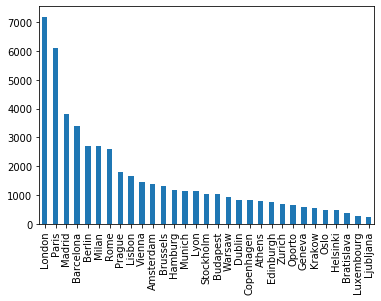

In [114]:
# Видим, что города сильно отличаются по количеству ресторанов
Cities.plot(kind = 'bar')

### 3. Cuisine Style
Номинальная переменная. Представлена списками. 11590 пропущенных значений. 


In [115]:
# Создадим отдельный столбец, в котором зафиксируем, что значение пропущено
data['Missing Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('uint8') 

# заполним пропуски значением 'Missing'
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Missing']")


In [116]:
# Вытащим в отдельный столбец типы кухонь в виде списка
data['Cuisine Style List'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'")

In [117]:
data['Cuisine Style List'].head()

0                                           [Bar, Pub]
1    [European, Scandinavian, Gluten Free Options, ...
2                                [Vegetarian Friendly]
3    [Italian, Mediterranean, European, Vegetarian ...
4    [Italian, Mediterranean, European, Seafood, Ve...
Name: Cuisine Style List, dtype: object

In [118]:
# Посчитаем количество уникальных типов кухонь
c = Counter()
for line in data['Cuisine Style List']:
    for cuisine_style in line:
        c[cuisine_style] += 1
cuisine_styles = pd.Series(c)
cuisine_styles.sort_values(ascending=False)

Vegetarian Friendly    14021
European               12561
Missing                11590
Mediterranean           7820
Italian                 7433
                       ...  
Polynesian                 2
Salvadoran                 1
Xinjiang                   1
Burmese                    1
Latvian                    1
Length: 126, dtype: int64

In [119]:
# Новый столбец - богатство выбора в ресторане (сколько типов кухонь и диетических предпочтений они предлагают)
data['Cuisine Style Options'] = data['Cuisine Style List'].apply(lambda x: len(x))

In [120]:
# удаляем номинальные признаки
data.drop(['Cuisine Style','Cuisine Style List',], axis = 1, inplace=True)

### 4. Ranking
Переменная в ранговой шкале. Пропусков нет. 

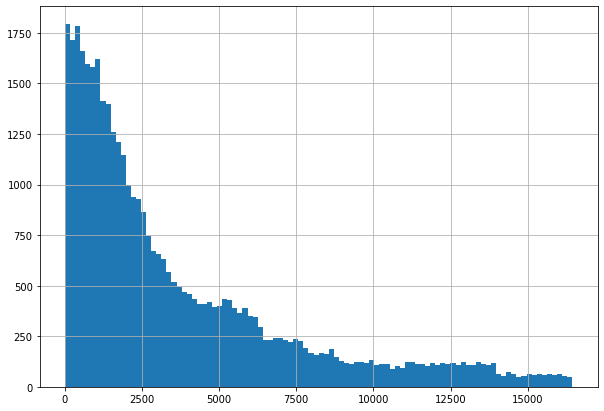

In [121]:
# Посмотрим на распределение признака
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

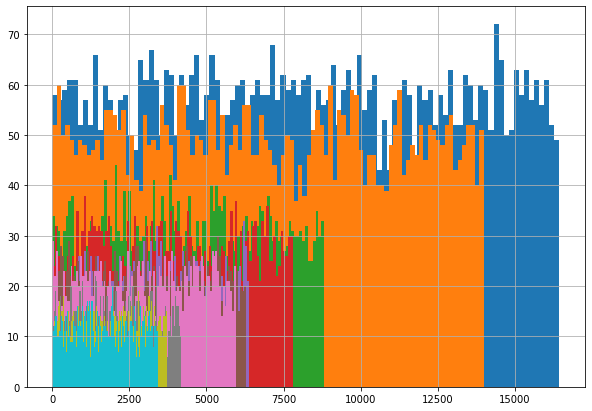

In [122]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Создадим переменную "относительный ранг" (Relative Ranking), чтобы сделать поправку на количество ресторанов в городе. Поскольку количество ресторанов в базе не отражает реальное количество ресторанов в городе, в качестве точки отсчета будем ориентироваться на максимальный ранг ресторана для каждого города в имеющейся выборке

In [123]:
# Найдем максимальный ранг ресторана в датасете для определенного города и сделаем из него словарь
city_max_rank = data.groupby('City').Ranking.max().to_dict()

In [124]:
# Теперь надо создать колонку максимального ранга и заполнить ее по словарю
data['Max Ranking for City'] = data['City'].apply(lambda x: city_max_rank.get(x))

In [125]:
# Создадим новую переменную - "относительный ранг" (Relative Ranking), 
# чтобы сделать поправку на разное количество ресторанов в городах
data['Relative Ranking'] = data['Ranking']/data['Max Ranking for City']

In [126]:
# проверим, получились ли нужные ранги. Порядок
data['Relative Ranking'].max()

1.0

### 5. Price Range
Номинальная переменная. 17361 пропуск.
\

In [127]:
# сохраним информацию о пропусках чтобы не потерять
data['Missing Price Range'] = pd.isna(data['Price Range']).astype('uint8') 

In [128]:
# Наибольшее количество ресторанов находятся в среднем ценовом сегменте
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [129]:
# Заполним пропуски модой
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

In [130]:
# заполним значения в переменной по словарю
price_to_num = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price Range Num'] = data['Price Range'].apply(lambda x: price_to_num.get(x))

In [131]:
# Удалим данные по цене в номинальной шкале
data.drop(['Price Range',], axis = 1, inplace=True)

### 6.Number of Reviews	
3200 пропусков. Количественная переменная.

In [132]:
# сохраним информацию о пропусках
data['Missing Number of Reviews'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [133]:
# Чаще всего отзывов два (мода)
data['Number of Reviews'].value_counts()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

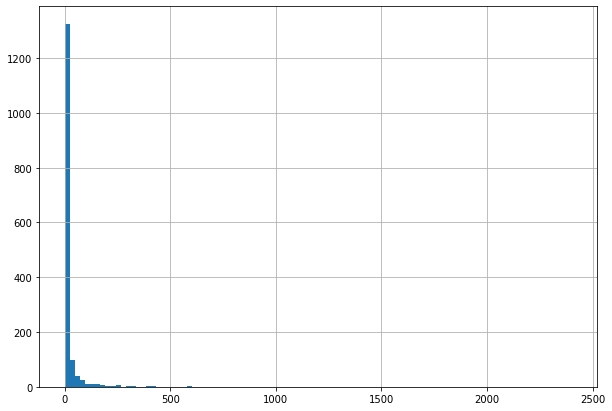

In [134]:
data['Number of Reviews'].value_counts().hist(bins=100)

In [135]:
data['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

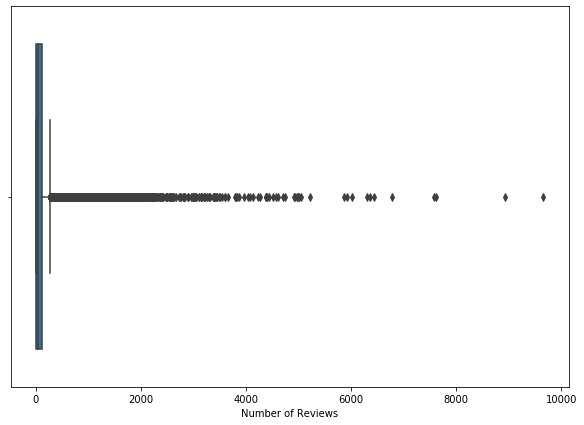

In [136]:
sns.boxplot(data['Number of Reviews'])

С точки зрения статистики, в количестве отзывов есть выбросы. Сложно их содержательно оценить, м.б. это действительно рестораны очень высокого уровня и у них резкий отрыв в количестве довольных посетителей. 

Пропуски предлагаю заполнить модой (2 отзыва). 

In [137]:
# Пока что заполним пропущенные значения модой 
data['Number of Reviews'] = data['Number of Reviews'].fillna(2)

### 7. Reviews
2 пропуска и 8112 пустых значений. Содержит тексты двух последних отзывов и даты этих отзывов. Формат данных - строка

In [138]:
# Количество пропусков
data.Reviews.isna().sum()

2

In [139]:
# Количество строчек с незаполненными данными - то есть, это тоже пропуски
len(data[data.Reviews == '[[], []]'])

8112

In [140]:
# Заполним два пропуска другим типом пустого значения, чтобы пустые значения выглядели одинаково
data.Reviews = data.Reviews.fillna('[[], []]')

In [141]:
# Зафиксируем информацию об отсутствии текста отзыва в отдельной колонке
data['Missing Reviews'] = data['Reviews'].apply(lambda x: 1 if x == '[[], []]' else 0)

> Извлекаем информацию о времени

In [142]:
# вытаскиваем в отдельную колонку даты. Пока что это список и строковый формат данных. 
data['Review Date'] = data['Reviews'].str.findall(r'\d+/\d+/\d+').to_list()

In [143]:
# Проверим, во всех ли строчках содержится по два значения даты. Для этого сделаем вспомогательный столбец
data['Num of Dates'] = data['Review Date'].apply(lambda x: len(x))

In [144]:
# Есть ситуация, когда три или одна дата
data['Num of Dates'].value_counts()

2    36202
0     8114
1     5680
3        4
Name: Num of Dates, dtype: int64

In [145]:
# Посмотрим на отзывы с тремя датами
data[data['Num of Dates'] == 3][['Review Date','Reviews']]

,Review Date,Reviews
2221,"[21/10/17, 12/22/2017, 10/19/2017]","[['We visited 21/10/17', 'Best Kebab in London..."
3809,"[30/5/2017, 04/13/2017, 05/30/2017]","[['Good Museum Cafeteria', 'Lunch 30/5/2017'],..."
19254,"[3/1/2017, 06/02/2017, 01/03/2017]","[['The desserts arcade !', 'Visit today 3/1/20..."
33348,"[29/9/2016, 09/30/2016, 08/25/2016]","[['lunch 29/9/2016', 'Unplanned Great Dinner']..."


Попали даты из текстов отзывов. Причем даты из отзывов написаны в формате день-месяц-год. Рестораны европейские, 
мб и посетители европейцы. А сам сайт американский, так что внутри даты в другом формате - месяц-день-год.

In [146]:
# Создаем отдельный признак с датами формата datetime
data['Review Date DT'] = data['Review Date'].apply(lambda x: pd.to_datetime(x))

In [147]:
# Каким-то чудесным образом компьютер все правильно обработал
data[data['Num of Dates'] == 3]['Review Date DT']

2221     DatetimeIndex(['2017-10-21', '2017-12-22', '20...
3809     DatetimeIndex(['2017-05-30', '2017-04-13', '20...
19254    DatetimeIndex(['2017-03-01', '2017-06-02', '20...
33348    DatetimeIndex(['2016-09-29', '2016-09-30', '20...
Name: Review Date DT, dtype: object

In [148]:
data['Review Date DT'].loc[3809]

DatetimeIndex(['2017-05-30', '2017-04-13', '2017-05-30'], dtype='datetime64[ns]', freq=None)

In [149]:
# там, где ситуация неочевидная, он все-таки перепутал
data['Review Date DT'].loc[19254]

DatetimeIndex(['2017-03-01', '2017-06-02', '2017-01-03'], dtype='datetime64[ns]', freq=None)

In [150]:
# Заморачиваться не буду, исправлю вручную. Поскольку дата дублируется, просто уберу ее
data['Review Date'].loc[19254] = data['Review Date'].loc[19254][1:]

In [151]:
# Задаем текущую дату
current_date = pd.datetime.now()

In [152]:
# Посмотрим на ситуацию, когда только одна дата отзыва
data[data['Num of Dates'] == 1]['Missing Number of Reviews'].value_counts()

0    4504
1    1176
Name: Missing Number of Reviews, dtype: int64

In [153]:
# Создадим колонки с датой первого и последнего отзыва
# Если дата одна, будем считать, что это дата и первого, и последнего отзыва
data['First Review Date'] = data['Review Date DT'].apply(lambda x: x.min())
data['Last Review Date'] = data['Review Date DT'].apply(lambda x: x.max())

In [154]:
# Создадим числовые колонки на основе признаков со временем
# Количество дней после последнего и первого отзыва, временной промежуток между отзывами в днях
data['Days from Last Review'] = (current_date - data['Last Review Date']).dt.days 
data['Days from First Review'] = (current_date - data['First Review Date']).dt.days
data['Days between Reviews'] = (data['Last Review Date'] - data['First Review Date']).dt.days

In [155]:
data['Days from Last Review'].describe()

count    41886.000000
mean      1277.045361
std        363.252094
min        987.000000
25%       1066.000000
50%       1140.000000
75%       1324.000000
max       6046.000000
Name: Days from Last Review, dtype: float64

In [156]:
data['Days between Reviews'].describe()

count    41886.000000
mean       123.218331
std        212.592518
min          0.000000
25%          8.000000
50%         49.000000
75%        148.000000
max       3296.000000
Name: Days between Reviews, dtype: float64

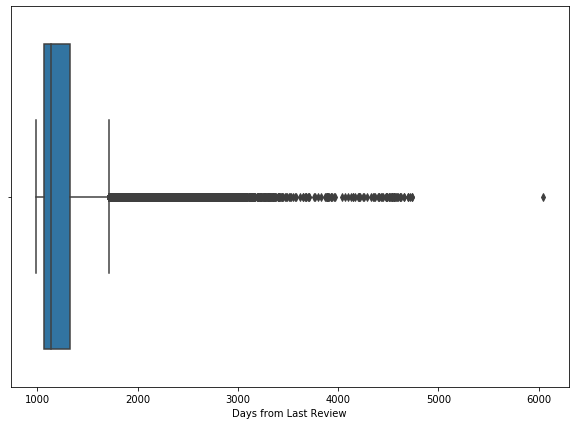

In [157]:
sns.boxplot(data['Days from Last Review'])

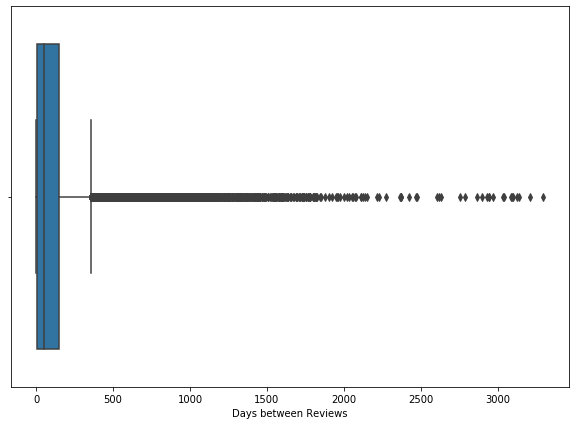

In [158]:
sns.boxplot(data['Days between Reviews'])

In [159]:
data['Days from Last Review'] = data['Days from Last Review'].fillna(0)
# data['Days from Last Review'] = data['Days from Last Review'].fillna(1137)

In [160]:
data['Days from First Review'] = data['Days from First Review'].fillna(0)
# data['Days from First Review'] = data['Days from First Review'].fillna(1254)

In [161]:
# Наверное, для удобства сразу надо делать именно такой расчет
data['Days between Reviews'] = data['Days from Last Review'] - data['Days from First Review']

In [162]:
data['Days between Reviews'].isna().sum()

0

In [163]:
data['Days from Last Review'].value_counts()

0.0       8114
1037.0     646
1041.0     568
1038.0     522
1040.0     492
          ... 
2644.0       1
2910.0       1
2662.0       1
3432.0       1
2388.0       1
Name: Days from Last Review, Length: 1977, dtype: int64

In [164]:
# Удалим ненужные переменные
data.drop(['Reviews', 'Review Date', 'Review Date DT', 'First Review Date', 'Last Review Date', 'Days from First Review'], axis = 1, inplace=True)

### 8. URL_TA
Ссылка на страницу ресторана на 'www.tripadvisor.com'


In [165]:
# Посмотрим, как выглядят данные
data['URL_TA'][0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

Можно вытащить название региона, города и ресторана, идентификатор ресторана. У нас уже есть несколько колонок с этой информацией. 
Этот столбец может понадобиться, если надо будет собрать дополнительную информацию с сайта Tripadvisor. Пока что я предлагаю этот столбец удалить. 

In [166]:
data.drop(['URL_TA'], axis = 1, inplace=True)

### 9. ID_TA
Идентификатор ресторана на сайте Tripadvisor. Никакой дополнительной информации не несет. Можно смело удалять. 

In [167]:
data.drop(['ID_TA'], axis = 1, inplace=True)

## Матрица корреляций

(14.0, 0.0)

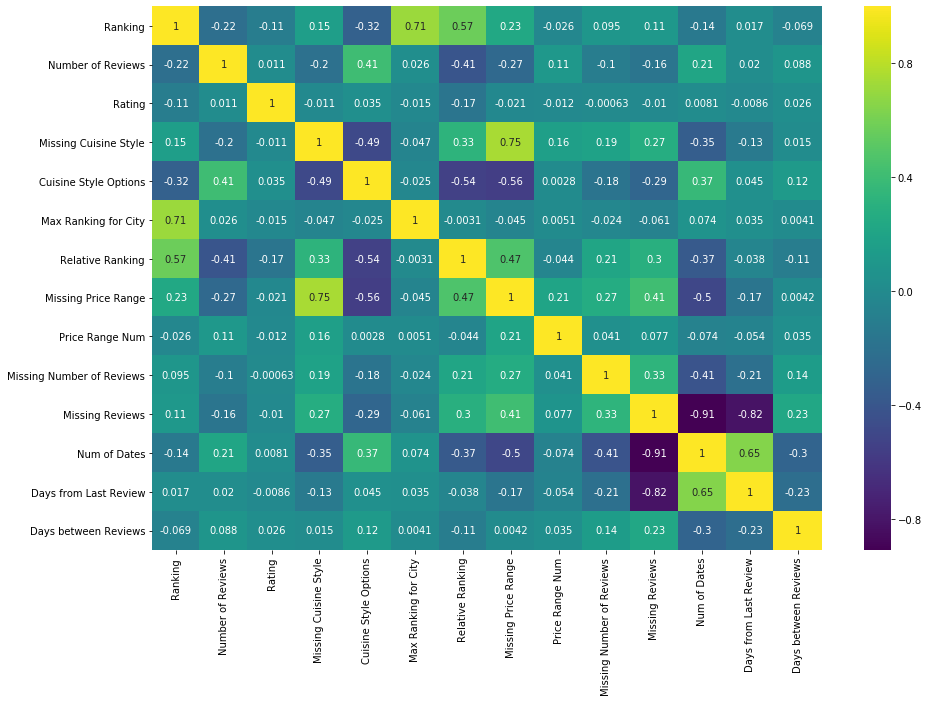

In [168]:
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.heatmap(data.drop(['sample'], axis=1).corr(), annot = True, cmap = 'viridis')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

# Дополнительная обработка данных

In [169]:
# Создадим dummy-переменные 
data = pd.get_dummies(data, columns=[ 'City'], dummy_na=True)

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 47 columns):
Ranking                      50000 non-null float64
Number of Reviews            50000 non-null float64
sample                       50000 non-null int64
Rating                       50000 non-null float64
Missing Cuisine Style        50000 non-null uint8
Cuisine Style Options        50000 non-null int64
Max Ranking for City         50000 non-null float64
Relative Ranking             50000 non-null float64
Missing Price Range          50000 non-null uint8
Price Range Num              50000 non-null int64
Missing Number of Reviews    50000 non-null uint8
Missing Reviews              50000 non-null int64
Num of Dates                 50000 non-null int64
Days from Last Review        50000 non-null float64
Days between Reviews         50000 non-null float64
City_Amsterdam               50000 non-null uint8
City_Athens                  50000 non-null uint8
City_Barcelona             

In [171]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [172]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [173]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 46), (40000, 46), (40000, 45), (32000, 45), (8000, 45))

# Построение модели
Сам ML

In [174]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [175]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [176]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [177]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.201585


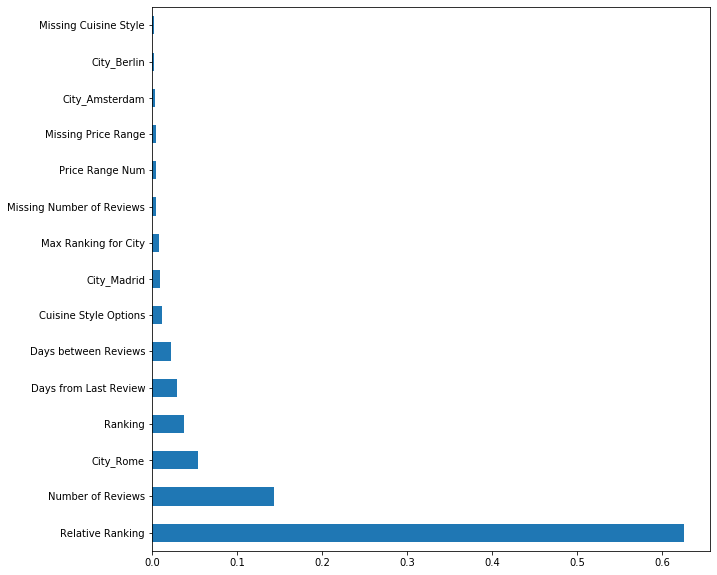

In [178]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Посмотрим на вклад отдельных признаков при построении модели. Как можно улучшить модель?

* Наибольший вклад вносит относительный ранг. Можно попробовать сделать этот показатель более точным, подгрузив внешние данные о количестве ресторанов в каждом городе 
* Извлечь больше информации из строковых переменных: типы кухонь, тексты отзывов


# Submission
Готовим Submission на кагл

In [179]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Missing Cuisine Style,Cuisine Style Options,Max Ranking for City,Relative Ranking,Missing Price Range,Price Range Num,Missing Number of Reviews,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
7239,3702.0,789.0,0.0,0,4,16444.0,0.225128,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2775,643.0,106.0,0.0,0,1,1484.0,0.433288,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1533,11929.0,3.0,0.0,0,1,16444.0,0.725432,0,2,0,...,0,0,0,0,0,0,0,0,0,0
7796,3011.0,8.0,0.0,0,1,6275.0,0.479841,1,2,0,...,0,0,0,0,0,0,0,0,0,0
9586,279.0,708.0,0.0,0,6,8809.0,0.031672,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1026,1608.0,2.0,0.0,0,3,2154.0,0.746518,0,1,1,...,0,0,0,0,0,0,0,1,0,0
2194,1857.0,17.0,0.0,0,2,1960.0,0.947449,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5033,7207.0,9.0,0.0,1,1,8809.0,0.818141,1,2,0,...,0,0,0,0,0,0,0,0,0,0
45,12709.0,49.0,0.0,0,1,13986.0,0.908694,0,2,0,...,0,0,1,0,0,0,0,0,0,0
161,1096.0,3.0,0.0,1,1,1244.0,0.881029,1,2,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
test_data = test_data.drop(['Rating'], axis=1)

In [181]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [182]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [183]:
predict_submission

array([3.055, 4.185, 4.445, ..., 3.1  , 4.5  , 4.335])

In [184]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.055
1,id_1,4.185
2,id_2,4.445
3,id_3,4.270
4,id_4,4.490
5,id_5,4.405
6,id_6,1.330
7,id_7,3.075
8,id_8,4.195
9,id_9,4.655
